#Introduction
In this notebook we create the graphs, node features, and define and train the various models. 
The two types of Graphs (Event/Char and Char only) are created first, and then the models and the training and testing functions are defined. Finally, there are executions with the cells already executed to display the output of the Test phase.

# Environment

## Installs

In [ ]:
!pip install sentence-transformers
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=8ca331d6b47ed57c62f4943f11726672db3f2981f5c3791eecd09538af8c62ab
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


## Mounting di GDrive

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
""" choose here whether you want to re-run on recap or summ, otherwise both will be loaded at train and test time"""
recap = True
summ = False

In [ ]:
SAVE = False #True to compute and save the features, False to only load them
SAVE_GRAPH = False #True to compute and save the graph
SAVE_GRAPH_EVENT_NODE = False

In [ ]:
"""
  choose for selecting which arc compose the training and test set and how to compute the feature:

  - "C1_C2_last_layer":  train arc 1-2-3 from campaign 1 , test arc 1-2 from campaign 2 , frature embedding last layer of bert embedding
  - "C1": train arc 1-2 from campaign 1 , test arc 3 from campaign 1 , 
  - "C1_C2_all_layer": train arc 1-2-3 from campaign 1 , test arc 1-2 from campaign 2 , frature embedding mean of last 4 layers of bert embedding
  - "C1_C2_last_layer_cleand": train arc 1-2-3 from campaign 1 , test arc 1-2 from campaign 2 , frature embedding mean of last 4 layers of bert embedding

 """
LOAD_FEAT = "C1_C2_last_layer_cleand" 

# LOAD_FEAT = "C1"

# LOAD_FEAT = "C1_C2_all_layer"

In [ ]:
LOAD = True #to be used to preload html pages

## Imports

In [ ]:
import torch

In [ ]:
# Install torch_geometric
import os
os.environ['TORCH'] = torch.__version__
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 13.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import torch.nn as nn

In [ ]:
import json
import csv 
from sentence_transformers import SentenceTransformer
from fuzzywuzzy import fuzz
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import networkx as nx
import matplotlib.pyplot as plt


/usr/local/lib/python3.9/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# import packets
import torch_geometric
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from torch_geometric.data import InMemoryDataset

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import seaborn as sn


In [ ]:
from torch_geometric.nn.conv import SAGEConv


In [ ]:
from tqdm import tqdm


In [ ]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn.dense import DenseGCNConv
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.nn.dense import DenseSAGEConv

In [ ]:
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## Paths

edit the ROOT_PATH if you wish to have access to files

In [ ]:
LINK_LIST_EPISODES = "https://criticalrole.fandom.com/wiki/List_of_episodes"
LINK_ORIGIN_EPISODE = "https://criticalrole.fandom.com/wiki/The_Story_of_Vox_Machina"
# root path used for drive access
ROOT_PATH= "/content/drive/MyDrive/Colab Notebooks/NUANS/project_bisazza_casadei/"
ROOT_PATH_OS= "/content/drive/MyDrive/Colab\ Notebooks/NUANS/project_bisazza_casadei/"

In [ ]:
DATA_PATH = os.path.join(ROOT_PATH, "data/")
DATA_PATH_OS = os.path.join(ROOT_PATH_OS, "data/")

In [ ]:
RECAP_PATH = os.path.join(str(DATA_PATH), "recap/")
RECAP_PATH_OS = os.path.join(str(DATA_PATH_OS), "recap/")

In [ ]:
ARC1_PATH = os.path.join(str(RECAP_PATH), "arc1.tsv")
ARC1_PATH_OS = os.path.join(str(RECAP_PATH_OS), "arc1.tsv")

In [ ]:
TL_PATH = os.path.join(str(DATA_PATH), "timeline/")
TL_PATH_OS = os.path.join(str(DATA_PATH_OS), "timeline/")

In [ ]:
SUM_PATH = os.path.join(str(DATA_PATH), "summaries/")
SUM_PATH_OS = os.path.join(str(DATA_PATH_OS), "summaries/")

In [ ]:
SUM_ARC1_PATH = os.path.join(str(SUM_PATH), "sum_arc1.tsv")
SUM_ARC1_PATH_OS = os.path.join(str(SUM_PATH_OS), "sum_arc1.tsv")

In [ ]:
PATH_GT_C = '/content/drive/MyDrive/Colab Notebooks/NUANS/project_bisazza_casadei/data/GT/characters/'
PATH_GT_R = '/content/drive/MyDrive/Colab Notebooks/NUANS/project_bisazza_casadei/data/GT/roles/'

In [ ]:
TL_events_PATH = os.path.join(str(DATA_PATH), "events/")
TL_events_PATH_OS = os.path.join(str(DATA_PATH_OS), "events/")

In [ ]:
PPR_PATH = os.path.join(str(DATA_PATH), "ppr/")
PPR_PATH_OS = os.path.join(str(DATA_PATH_OS), "ppr/")

In [ ]:
GNN_features_PATH = os.path.join(str(DATA_PATH), "GNN_features/")
GNN_features_PATH_OS = os.path.join(str(DATA_PATH_OS), "GNN_features/")

In [ ]:
TL_PATH_C2 = os.path.join(str(DATA_PATH), "timeline_C2/")
TL_PATH_OS_C2 = os.path.join(str(DATA_PATH_OS), "timeline_C2/")
TL_COREF_PATH_C2= os.path.join(str(DATA_PATH), "timeline_C2/timeline-coref-substitued/")
TL_COREF_PATH_OS_C2 = os.path.join(str(DATA_PATH_OS), "timeline_C2/timeline-coref-substitued/")

In [ ]:
TL_events_PATH_C2 = os.path.join(str(DATA_PATH), "events_C2/")
TL_events_PATH_OS_C2 = os.path.join(str(DATA_PATH_OS), "events_C2/")

In [ ]:
SUM_PATH_C2 = os.path.join(str(DATA_PATH), "summaries_C2/")
SUM_PATH_OS_C2 = os.path.join(str(DATA_PATH_OS), "summaries_C2/")
SUM_COREF_PATH_C2 = os.path.join(str(DATA_PATH), "summaries_C2/summaries-coref-substitued/")
SUM_COREF_PATH_OS_C2 = os.path.join(str(DATA_PATH_OS), "summaries_C2/summaries-coref-substitued/")


## Loads

In [ ]:
""" load JSON file (return a dictionary)"""
def loadJSON(path,name):
  # print(f"- loading JSON file: {name}.json, at: {path} ...")
  with open(path + name + '.json', 'r') as f:
    data = json.load(f)
  return data
  
""" save JSON file """
def saveJSON(data, name, path = './', download = True):
    # print(f"- saving JSON file: {name}.json, at: {path} ...")
    with open(path + name + '.json', 'w') as f:
        json.dump(data, f, indent=4,default=lambda x: str(x))
    if download: 
        files.download(path + name + '.json')


In [ ]:
if SAVE_GRAPH==True or SAVE_GRAPH_EVENT_NODE== True:
  character_dictionary = {}
  character_dictionary = loadJSON(PATH_GT_C,'gt_characters_arc1')

  npc_dictionary ={}
  npc_dictionary = loadJSON(PATH_GT_R,'all_NPCs')

In [ ]:

arc_1_TL_events_CHAR_ONLY =loadJSON(TL_events_PATH, 'arc_1-TL_coref_events_CHAR_ONLY-json')
arc_2_TL_events_CHAR_ONLY =loadJSON(TL_events_PATH, 'arc_2-TL_coref_events_CHAR_ONLY-json')
arc_3_TL_events_CHAR_ONLY =loadJSON(TL_events_PATH, 'arc_3-TL_coref_events_CHAR_ONLY-json')


In [ ]:

arc_1_TL_events_char_dict =loadJSON(TL_events_PATH, 'arc_1-TL_coref_events_CHAR_ONLY-json_char_dict')
arc_2_TL_events_char_dict =loadJSON(TL_events_PATH, 'arc_2-TL_coref_events_CHAR_ONLY-json_char_dict')
arc_3_TL_events_char_dict =loadJSON(TL_events_PATH, 'arc_3-TL_coref_events_CHAR_ONLY-json_char_dict')



In [ ]:

arc_1_recap_events_CHAR_ONLY =loadJSON(TL_events_PATH, 'arc_1-recap_coref_events_CHAR_ONLY-json')
arc_2_recap_events_CHAR_ONLY =loadJSON(TL_events_PATH, 'arc_2-recap_coref_events_CHAR_ONLY-json')
arc_3_recap_events_CHAR_ONLY =loadJSON(TL_events_PATH, 'arc_3-recap_coref_events_CHAR_ONLY-json')


In [ ]:

arc_1_recap_events_char_dict =loadJSON(TL_events_PATH, 'arc_1-recap_coref_events_CHAR_ONLY-json_char_dict')
arc_2_recap_events_char_dict =loadJSON(TL_events_PATH, 'arc_2-recap_coref_events_CHAR_ONLY-json_char_dict')
arc_3_recap_events_char_dict =loadJSON(TL_events_PATH, 'arc_3-recap_coref_events_CHAR_ONLY-json_char_dict')



In [ ]:

arc_1_summ_events_CHAR_ONLY =loadJSON(TL_events_PATH, 'arc_1-summ_coref_events_CHAR_ONLY-json')
arc_2_summ_events_CHAR_ONLY=loadJSON(TL_events_PATH, 'arc_2-summ_coref_events_CHAR_ONLY-json')
arc_3_summ_events_CHAR_ONLY =loadJSON(TL_events_PATH, 'arc_3-summ_coref_events_CHAR_ONLY-json')


In [ ]:

arc_1_summ_events_char_dict =loadJSON(TL_events_PATH, 'arc_1-summ_coref_events_CHAR_ONLY-json_char_dict')
arc_2_summ_events_char_dict =loadJSON(TL_events_PATH, 'arc_2-summ_coref_events_CHAR_ONLY-json_char_dict')
arc_3_summ_events_char_dict =loadJSON(TL_events_PATH, 'arc_3-summ_coref_events_CHAR_ONLY-json_char_dict')



In [ ]:



arc_1_C2_recap_events_CHAR_ONLY =loadJSON(TL_events_PATH_C2, 'arc_1-recap_coref_events_CHAR_ONLY-json')
arc_2_C2_recap_events_CHAR_ONLY =loadJSON(TL_events_PATH_C2, 'arc_2-recap_coref_events_CHAR_ONLY-json')


In [ ]:

arc_1_C2_recap_events_char_dict =loadJSON(TL_events_PATH_C2, 'arc_1-recap_coref_events_CHAR_ONLY-json_char_dict')
arc_2_C2_recap_events_char_dict =loadJSON(TL_events_PATH_C2, 'arc_2-recap_coref_events_CHAR_ONLY-json_char_dict')

In [ ]:



arc_1_C2_summ_events_CHAR_ONLY =loadJSON(TL_events_PATH_C2, 'arc_1-summ_coref_events_CHAR_ONLY-json')
arc_2_C2_summ_events_CHAR_ONLY =loadJSON(TL_events_PATH_C2, 'arc_2-summ_coref_events_CHAR_ONLY-json')


In [ ]:

arc_1_C2_summ_events_char_dict =loadJSON(TL_events_PATH_C2, 'arc_1-summ_coref_events_CHAR_ONLY-json_char_dict')
arc_2_C2_summ_events_char_dict =loadJSON(TL_events_PATH_C2, 'arc_2-summ_coref_events_CHAR_ONLY-json_char_dict')

### Choose execution variables


here if you want you can edit which arcs are part of the train and test dataset

In [ ]:
# unite the dictionary for training 

def unite_cahr_dict(train_char_dict, dict_list):
  for dict2 in dict_list:
    for key, value in dict2.items():
      train_char_dict[key] = train_char_dict.get(key, []) + value
  return train_char_dict



In [ ]:
# train_char_dict = arc_1_recap_events_char_dict
if recap == True:
  train_char_dict = arc_1_recap_events_char_dict.copy()
  dict_list = [arc_2_recap_events_char_dict.copy(), arc_3_recap_events_char_dict.copy()]
  train_char_dict = unite_cahr_dict(train_char_dict, dict_list)

  train_event_dict = arc_1_recap_events_CHAR_ONLY+arc_2_recap_events_CHAR_ONLY +arc_3_recap_events_CHAR_ONLY


  test_char_dict = arc_1_C2_recap_events_char_dict.copy()
  dict_list = [arc_2_C2_recap_events_char_dict.copy()]
  test_char_dict = unite_cahr_dict(test_char_dict, dict_list)

  test_event_dict = arc_1_C2_recap_events_CHAR_ONLY + arc_2_C2_recap_events_CHAR_ONLY
if summ == True:
  train_char_dict = arc_1_summ_events_char_dict.copy()
  dict_list = [arc_2_summ_events_char_dict.copy(), arc_3_summ_events_char_dict.copy()]
  train_char_dict = unite_cahr_dict(train_char_dict, dict_list)

  train_event_dict = arc_1_summ_events_CHAR_ONLY+arc_2_summ_events_CHAR_ONLY +arc_3_summ_events_CHAR_ONLY


  test_char_dict = arc_1_C2_summ_events_char_dict.copy()
  dict_list = [arc_2_C2_summ_events_char_dict.copy()]
  test_char_dict = unite_cahr_dict(test_char_dict, dict_list)

  test_event_dict = arc_1_C2_summ_events_CHAR_ONLY + arc_2_C2_summ_events_CHAR_ONLY

# Feature encoding 

the dictionary containing the features representing each character is created, saved and/or loaded here

## Transoformers embeddings

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertModel, BertTokenizer, logging
import torch as T
import numpy as np
import pandas as pd
PATH_PROJECT_FOLDER = "/content/drive/MyDrive/Colab Notebooks/NUANS/project_bisazza_casadei/"

logging.set_verbosity_error()


"""
          Read tsv file (default Verbatlas frames file)
"""
def readVAFrames(file_csv_name = "VA_frame_info.tsv", show = False):
  df = pd.read_csv(PATH_PROJECT_FOLDER + file_csv_name, sep='\t', index_col = False, header = None, skiprows = [0])
  if show: display(df)
  list_sent = df.to_numpy()
  target_description = list_sent.tolist()
  return target_description



"""
          Load Bert Model & Tokenizer
"""
def init_embedding():
  
  # 1) load Bert model

  global device, tokenizer, bert

  device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

  # load the bert tokenizer (CPU)
  tokenizer =  BertTokenizer.from_pretrained('bert-base-uncased')

  # load the Bert embedding model (GPU/CPU)
  bert = BertModel.from_pretrained('bert-base-uncased', add_pooling_layer = True)
  bert.eval()
  bert.to(device)

  # 2) load verbatlas data

  global names_frame, descriptions_frame, meanings_frame, synonyms_frame

  VA_frame_list = readVAFrames()

  # create a list for each column of interest
  names_frame = [row[1] for row in VA_frame_list]
  descriptions_frame = [row[2] for row in VA_frame_list]
  meanings_frame = [row[4] for row in VA_frame_list]
  synonyms_frame = [row[5] for row in VA_frame_list]


"""
          Using Bert model return tokens and embeedding of sentence (parameter)
          mode:
                "last layer" -> return tokens embedding just from the last layer
                "pooling" -> return embedding for the sentence 
                "all layers" -> return tokens embedding from all the layers
"""
def get_TokensEmb(sentence, mode = "last layer", verbose = False):
  
  # add special tokens to sentence
  sentence = "[CLS]"+ sentence + "[SEP]"
  
  # tokenize the text
  tokens_sent = tokenizer.tokenize(sentence, truncation = False)

  # covert to bert ids, then create the tensor and use GPU whether available
  tokens_ids_sent = T.tensor([tokenizer.convert_tokens_to_ids(tokens_sent)]).to(device)

  # embedding forward
  with T.no_grad():
    bert_result = bert(tokens_ids_sent, output_hidden_states= True) 

  if mode == "last layer":
    emb_sent = bert_result.last_hidden_state      # take embedding from last layer
  elif mode == 'pooling':
    emb_sent = bert_result.pooler_output          # take sentence embedding from pooling layer
  elif mode == 'all layers':
    emb_sent = bert_result.hidden_states          # take all the hidden layers
    emb_sent = T.stack(emb_sent, dim=0)
    # print(emb_sent.size)
    # print(emb_sent.shape)

    
  # if mode == "all layers":
  #   emb_sent = torch.sum(token[-4:], dim=0)

  
  if mode == "last layer" or  mode == "pooling":
    emb_sent = emb_sent.cpu().numpy()
    emb_sent = np.squeeze(emb_sent, axis = 0)

  elif mode == "all layers":
    emb_sent = T.squeeze(emb_sent, axis = 1)
    emb_sent = T.sum(emb_sent[-4:], dim=0).cpu().numpy()

  if verbose:
    print("Tokens sentence -> {}\n".format(tokens_sent))
    print("Tokens sentence IDs-> {}\n".format(tokens_ids_sent))
    print("Shape sentence embedding -> {}\n".format(emb_sent.shape))
    print("Sentence embedding-> {}\n".format(emb_sent))

  return tokens_sent, emb_sent


"""
          Return the Character(word) embedding from a sentence
          modes:
                first -> return the embedding of the first match if the name is composed name
                mean  -> return the embedding doing the mean if more tokens match the name (composed)
"""
def get_featureChar(sentence, name, mode = "first", verbose = False):

  # insert name in the vocabulary to avoid splitting in different tokens or subwords
  if not(name.lower().strip() in tokenizer.get_vocab()):
    tokenizer.add_tokens(name.lower().strip())
    bert.resize_token_embeddings(len(tokenizer))

  # get embeddings and tokens
  tokens, emb= get_TokensEmb(sentence, "last layer",verbose = verbose)

  # get array of words from name
  words_name = name.split()

  # initialize the list of matching for 'mean' mode
  if mode == 'mean': embs = []

  # loop over the tokens for matching
  for idx,token in enumerate(tokens):

    token = token.replace('#','').strip()

    # if token in one of the name's words
    # if any([word_name.lower().strip() == token.lower().strip() for word_name in words_name]):
    if name.lower().strip() in token.lower().strip():

      if verbose: print("matching name-> {}, with token -> {}".format(name, token))

      # return or store embedding found
      if mode == 'first':
        if verbose: print("final shape-> {}".format(emb[idx].shape))
        return emb[idx].tolist()
      elif mode == 'mean':
        embs.append(emb[idx].tolist())

  # if nothing has been found raise an error, in 'mean' mode compute the final result and return
  if mode == 'first':
    raise ValueError("Character embeddding: no word-token match")

  elif mode == 'mean':
    if embs == []:
      print(f"name : {name}, not in sentence: {sentence}")
      print("Character embeddding: no word-token match")
      return [0 for i in range(768)]

    else:
      mean_emb = np.mean(embs, axis = 0)
      if verbose: print("final shape-> {}".format(mean_emb.shape))
      return mean_emb.tolist()


"""
          Return the Event embedding from the frame name
"""
def get_featureEvent(frame_name, verbose = False):
  if verbose: print("\nSTARTING A NEW FRAME")
  idx_frame = -1

  # found index of the frame and extract, if frame description contains uppercase keywords, extract them
  for idx, (name_frame, description_frame, synonym_frame) in enumerate(zip(names_frame,descriptions_frame, synonyms_frame)):

    if name_frame != frame_name: continue

    idx_frame = idx

    # make lower first character and split 
    words_description = description_frame[0].lower() + description_frame[1:]
    words_description = words_description.split()
    
    # define array for the words whose embedding we are interested
    words_description_upper = []

    # filter to get only capital part of the description
    for idx, word in enumerate(words_description):
      if word.isupper():
        if "-" in word:                         
          for _word in word.split("-"):
            words_description_upper.append(_word)
        else:
          words_description_upper.append(word)

    
    if words_description_upper == []:
      if verbose:print("No matching in the frame description found. Description frame-> {}\n".format(description_frame))

    else:
      if verbose:print("Matching in the frame description found, words matching -> {}\n".format(description_frame))
      if verbose:print(words_description_upper)

  # if not frame with the name spaciefied raise error
  if idx_frame == -1: 
    if verbose:print("Event embedding error: not possible to find the requested frame, returning None")
    return None

  
  embs = []  # list of embeddings to store
  
  # get embedding from using the keywords extracted if exist
  if not (words_description_upper == []):

    description_frame = descriptions_frame[idx_frame]
    # make first word of the sentence lower
    description_frame = description_frame[0].lower() + description_frame[1:]

    tokens, emb= get_TokensEmb(descriptions_frame[idx_frame], mode = "last layer", verbose = verbose )
    for idx, token in enumerate(tokens):
      if any([target.lower().strip() in token.lower().strip() for target in words_description_upper]):

        if verbose: print("matching name-> {}, with token -> {}".format(words_description_upper, token))
        embs.append(emb[idx])

    if embs != []:
      embs = np.array(embs)
      if verbose:print(embs.shape)
      outcome = np.mean(embs, axis = 0)
      if verbose:print(outcome.shape)
      return outcome.tolist()

  # case of no keywords found or no matching on keywords (words_description_upper == [] or embs == [])
  _ , emb= get_TokensEmb(meanings_frame[idx_frame], mode = 'pooling', verbose = verbose)
  if verbose:
    print("Doing sentence embedding for the following meaning sentence:\n {}".format(meanings_frame[idx_frame]))
    print("emb",emb.shape)
    print("retrun type(np.mean(emb, axis = 0).tolist())", type(np.mean(emb, axis = 0).tolist()))
  if len(emb.shape) == 1:
      result = emb.tolist()
  else:
      # handle the case where emb is not 1-dimensional
      result = np.mean(emb, axis = 0).tolist()
  return result

def get_featureEvent_meaning(frame_name, verbose = False):

  idx_frame = -1

  # found index of the frame and extract, if frame description contains uppercase keywords, extract them
  for idx, (name_frame, description_frame, synonym_frame) in enumerate(zip(names_frame,descriptions_frame, synonyms_frame)):
    if name_frame != frame_name: continue
    idx_frame = idx

  # if not frame with the name spaciefied raise error
  if idx_frame == -1: 
    if verbose:print("Event embedding error: not possible to find the requested frame, returning None")
    return None

  # case of no keywords found or no matching on keywords (words_description_upper == [] or embs == [])
  _ , emb= get_TokensEmb(meanings_frame[idx_frame], mode = 'pooling', verbose = verbose)
  if verbose:
    print("Doing sentence embedding for the following meaning sentence:\n {}".format(meanings_frame[idx_frame]))
    print("emb",emb.shape)
    print("retrun type(np.mean(emb, axis = 0).tolist())", type(np.mean(emb, axis = 0).tolist()))
  if len(emb.shape) == 1:
      result = emb.tolist()
  else:
      # handle the case where emb is not 1-dimensional
      result = np.mean(emb, axis = 0).tolist()
  return result

if SAVE== True: init_embedding()

 test

In [ ]:
"""
                example of use
"""

sentence = "Yesterday Percival De Rolo, Franco and Roberto played the piano all the day"
word = "Percival De Rolo"
# print((get_featureChar(sentence, word, mode= 'mean', verbose = True)))


# frame_name = "RETAIN_KEEP_SAVE-MONEY"
# print((get_featureEvent_meaning(frame_name, verbose = True)))

## Precompute  feature dictionary

In [ ]:
import torch
import torch.nn.functional as F

def create_feature_dictionary_new(TL_char_dict):
    """
    Creates feature dictionary for all the characters and their sentences representation.

    Parameters:
    - TL_char_dict: dictionary of characters and their sentences
    - model: trained sentence embedding model
    - max_len: maximum length of sentence representation among all characters (default=None)
    - debug: flag to enable debugging information (default=False)

    Returns:
    - feature_dict: dictionary of characters and their sentence representation
    - max_len: maximum length of sentence representation among all characters
    """
    feature_dict = {}
    character_representations = []

    for character, sentences in TL_char_dict.items():
      for sentence in sentences:
        
        character_representations.append(get_featureChar(sentence, character, mode= 'mean', verbose = False))
      character_representations_t =   torch.tensor(character_representations).mean(dim=0)
      feature_dict[character] = character_representations_t

    return feature_dict


In [ ]:
if SAVE ==True: 
  train_feature_dict = create_feature_dictionary_new(train_char_dict)
  # test_feature_dict = create_feature_dictionary_new(test_char_dict)

In [ ]:
# a = []
# b = []
# for character, sentences in train_char_dict.items():
#    a.append(len(sentences))
# for character, sentences in test_char_dict.items():
#    b.append(len(sentences))
# max_len = max(max(a), max(b))

### Save feature

In [ ]:
"""train_feature_dict
specify the file path to save your dictionary"""
if summ == True:
  file_name = "summ_"
elif recap == True:
  file_name = "recap_"

if LOAD_FEAT == "C1_C2_last_layer" or LOAD_FEAT =="C1_C2_last_layer_cleand":
  file_name+= 'train_feature_dict_a1_a2_a3_C1-last_layer.pt'
  train_save_file_path = os.path.join(str(GNN_features_PATH), file_name)
elif LOAD_FEAT == "C1":
  file_name+= 'train_feature_dict.pt'
  train_save_file_path = os.path.join(str(GNN_features_PATH), file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  file_name+= 'train_feature_dict_a1_a2_a3_C1.pt'
  train_save_file_path = os.path.join(str(GNN_features_PATH), file_name)

"""save your dictionary to a file"""


if SAVE ==True: 
  torch.save(train_feature_dict, train_save_file_path)

In [ ]:
# test_feature_dict
if summ == True:
  file_name = "summ_"
elif recap == True:
  file_name = "recap_"
# specify the file path to save your dictionary
if LOAD_FEAT == "C1_C2_last_layer" or LOAD_FEAT =="C1_C2_last_layer_cleand":
  file_name+= 'test_feature_dict_a1_a2_C2-last_layer.pt'
  test_save_file_path = os.path.join(str(GNN_features_PATH), file_name)
elif LOAD_FEAT == "C1":
  file_name+= 'test_feature_dict.pt'
  test_save_file_path = os.path.join(str(GNN_features_PATH), file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  file_name+= 'test_feature_dict_a1_a2_C2.pt'
  test_save_file_path = os.path.join(str(GNN_features_PATH), file_name)
# save your dictionary to a file


if SAVE ==True: 
  torch.save(test_feature_dict, test_save_file_path)

### Load features

In [ ]:
# load your dictionary from a file


if SAVE_GRAPH==True or SAVE_GRAPH_EVENT_NODE== True:
  train_feature_dict = torch.load(train_save_file_path)
  test_feature_dict = torch.load(test_save_file_path)




#Event/Char Graph
we use NetworkX library to create the graph. The graph has two types of nodes: char and event. The char nodes have the feature computed above . The event nodes have as feature the embedding of the meanings of the Verbaltas Frame. 

In [ ]:

def flatten(lst):
    result = []
    if lst == "empty":
      return []
    if isinstance(lst, str):
      return [lst]
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result
def build_event_graph(events_dict_list, feature_dict, debug = False ):
    """
    Builds a graph of events, where each event is connected to its characters.
    """
    graph = nx.Graph()
    
    for event_dict in events_dict_list:
        event = event_dict['event']
        event_node = f"{event}_{events_dict_list.index(event_dict)}" # Add the index of the event to the event node name to make it unique
        FrameFeature = get_featureEvent(event, verbose = False ) 
        if FrameFeature ==None : continue
        FrameFeature = torch.Tensor(FrameFeature) # Framefeature is always a single scalar, that's wht is max-len -1
        graph.add_node(event_node, type="event", Feature = FrameFeature , role=['None'])
        
        for char_tuple in event_dict['characters']:
            char_item, VaRole = char_tuple
            
            char_node = f"{char_item['token']}"
            if char_item['role']:
              roles = flatten(char_item['role'])
              if "main" in roles or "antagonist" in roles or "npc" in roles or "ally" in roles:
                char_role = roles
              else:
                continue
            else :
              continue

            CharFeature=feature_dict[char_node]
            # VaRoleFeature = get_word_embedding(VaRole, sentence, model)
            graph.add_node(char_node, type="char",Feature=CharFeature, role=char_role)
            graph.add_edge(char_node, event_node)
            
        
    return graph


## Call build_event_graph

In [ ]:
if SAVE_GRAPH_EVENT_NODE == True:
  train_G = build_event_graph(train_event_dict, train_feature_dict, debug = False)
  test_G = build_event_graph(test_event_dict,test_feature_dict, debug = False)

In [ ]:


import networkx as nx
import json
import numpy as np
import torch

from networkx.readwrite import json_graph

def save_graph(G, save_graph_name):
  # convert the graph to JSON-serializable format
  data = json_graph.node_link_data(G)

  # convert numpy arrays to lists
  for node in data['nodes']:
      node['Feature'] = node['Feature'].tolist()
  # for edge in data['links']:
  #     if isinstance(edge['VaRoleFeature'],float):
  #       edge['VaRoleFeature'] = [edge['VaRoleFeature']]
  #     else:
  #       edge['VaRoleFeature'] = edge['VaRoleFeature'].tolist()

  # save the data to a JSON file
  with open(save_graph_name, 'w') as f:
      json.dump(data, f)
def load_graph_event_char(load_graph_name):
  # load the data from the JSON file
  with open(load_graph_name, 'r') as f:
      data = json.load(f)

  # convert the data back to a graph
  G = json_graph.node_link_graph(data)

  # convert lists back to numpy arrays
  for node in G.nodes(data=True):
      node[1]['Feature'] = np.array(node[1]['Feature'])
  # for edge in G.edges(data=True):
  #     edge[2]['VaRoleFeature'] = np.array(edge[2]['VaRoleFeature'])
  return G


### Save graph

In [ ]:

# save the graph as a GraphML file
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if SAVE_GRAPH_EVENT_NODE == True:
  if LOAD_FEAT == "C1_C2_last_layer" :
    g_file_name += "C1_C2_train_G-last_layer.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  elif LOAD_FEAT == "C1":
    g_file_name += "C1_train_G.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  elif LOAD_FEAT == "C1_C2_all_layer":
    g_file_name += "C1_C2_train_G-all_layers.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  elif LOAD_FEAT =="C1_C2_last_layer_cleand":
    g_file_name += "C1_C2_train_G-last_layer-cleands.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  save_graph(train_G, save_graph_name)

In [ ]:
# save the graph as a GraphML file
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if SAVE_GRAPH_EVENT_NODE == True:
  if LOAD_FEAT == "C1_C2_last_layer":
    g_file_name += "C1_C2_test_G-last_layer.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  elif LOAD_FEAT == "C1":
    g_file_name += "C1_test_G.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  elif LOAD_FEAT == "C1_C2_all_layer":
    g_file_name += "C1_C2_test_G-all_layers.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  elif LOAD_FEAT =="C1_C2_last_layer_cleand":
    g_file_name += "C1_C2_test_G-last_layer-cleand.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  save_graph(test_G, save_graph_name)

### Load graph

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer" :
  g_file_name += "C1_C2_train_G-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_train_G.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_train_G-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT =="C1_C2_last_layer_cleand":
    g_file_name += "C1_C2_train_G-last_layer-cleands.json"
    load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
train_G = load_graph_event_char(load_graph_name)

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer" :
  g_file_name += "C1_C2_test_G-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_test_G.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_test_G-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT =="C1_C2_last_layer_cleand":
    g_file_name += "C1_C2_test_G-last_layer-cleand.json"
    load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
test_G = load_graph_event_char(load_graph_name)

### Print graph

In [ ]:
def print_graph(G):
  node_colors = []
  for node in G.nodes:
      if node in G.nodes(data=True):
          node_data = G.nodes[node]
          t = node_data.get('type')
          if t == 'event':
            node_colors.append('gray')
          else:
            role = node_data.get('role')
            if role:
              if 'main' in role:
                  node_colors.append('blue')
              elif 'ally' in role:
                  node_colors.append('cyan')
              elif 'antagonist' in role:
                  node_colors.append('red')
              elif 'npc' in role:
                  node_colors.append('cyan')
              else:
                node_colors.append('purple')
            else:
                node_colors.append('green') 

  # draw the graph
  pos = nx.fruchterman_reingold_layout(G)
  plt.figure(figsize=(40,30))
  degree_centrality = nx.degree_centrality(G)

  # set node size based on degree centrality
  node_size = [v * 1000 for v in degree_centrality.values()]

  nx.draw(G, pos, node_color=node_colors ,node_size=node_size, with_labels=True,  font_size=7)
  plt.show()

In [ ]:
#  print_graph(train_G)

In [ ]:
#  print_graph(test_G)

#Char Graph
we use NetworkX library to create the graph. The graph has only Char nodes. The char nodes have the feature computed above . The edges are the Event nodes of previopus Graph and  have as feature the embedding of the meanings of the Verbaltas Frame(as before). 

##build_event_graph_solo_char

In [ ]:

def build_event_graph_solo_char(events_dict_list, feature_dict, debug = False, verbose = False ):
    """
    Builds a graph of events, where each event is connected to its characters.
    """
    graph = nx.Graph()
    
    for event_dict in events_dict_list:
        event = event_dict['event']
        event_node = f"{event}_{events_dict_list.index(event_dict)}" # Add the index of the event to the event node name to make it unique
        # sentence = get_row_by_word(file_name, event) #legge il file di verbatlas per avere la descrizione del event frame
        # if debug: print(f"[0]build_event_graph: event: {event},  sentence:  {sentence}")
        # if sentence==None: continue
        FrameFeature = get_featureEvent_meaning(event, verbose = verbose ) 
        if FrameFeature ==None : continue
        FrameFeature = torch.Tensor(FrameFeature) # Framefeature is always a single scalar, that's wht is max-len -1
        char_edge_list=[]
        for char_tuple in event_dict['characters']:
            char_item, VaRole = char_tuple
           
            char_node = f"{char_item['token']}"
            if char_item['role']:
              roles = flatten(char_item['role'])
              if "main" in roles or "antagonist" in roles or "npc" in roles or "ally" in roles:
                char_role = roles
              else:
                continue
            else :
              continue

            CharFeature=feature_dict[char_node]
            # VaRoleFeature = get_word_embedding(VaRole, sentence, model)
            graph.add_node(char_node, type="char",Feature=CharFeature, role=char_role)
            char_edge_list.append(char_node)
        for i in range(len(char_edge_list)):
          for j in range(i+1, len(char_edge_list)):
              graph.add_edge(char_edge_list[i], char_edge_list[j], Feature = FrameFeature)

        
    return graph


## call build_event_graph

In [ ]:
if SAVE_GRAPH == True:
  train_G_solo_c = build_event_graph_solo_char(train_event_dict, train_feature_dict, debug = False, verbose = False)
  test_G_solo_c = build_event_graph_solo_char(test_event_dict , test_feature_dict, debug = False, verbose = False)

In [ ]:


import networkx as nx
import json
import numpy as np
import torch

from networkx.readwrite import json_graph

def save_graph(G, save_graph_name):
  # convert the graph to JSON-serializable format
  data = json_graph.node_link_data(G)
  print(data.keys())
  # convert numpy arrays to lists
  for node in data['nodes']:
      node['Feature'] = node['Feature'].tolist()
  for edge in data['links']:
      edge['Feature'] = edge['Feature'].tolist()

  # save the data to a JSON file
  with open(save_graph_name, 'w') as f:
      json.dump(data, f)
def load_graph(load_graph_name):
  # load the data from the JSON file
  with open(load_graph_name, 'r') as f:
      data = json.load(f)

  # convert the data back to a graph
  G = json_graph.node_link_graph(data)

  # convert lists back to numpy arrays
  for node in G.nodes(data=True):
      node[1]['Feature'] = np.array(node[1]['Feature'])
  for edge in G.edges(data=True):
      edge[2]['Feature'] = np.array(edge[2]['Feature'])
  return G


### Save graph

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
# save the graph as a GraphML file
if SAVE_GRAPH == True:
  if LOAD_FEAT == "C1_C2_last_layer":
    g_file_name += "C1_C2_train_G_solo_c-last_layer.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  elif LOAD_FEAT == "C1":
    g_file_name += "C1_train_G_solo_c.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  elif LOAD_FEAT == "C1_C2_all_layer":
    g_file_name += "C1_C2_train_G_solo_c-all_layers.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  elif LOAD_FEAT == "C1_C2_last_layer_cleand" :
    g_file_name += "C1_C2_train_G_solo_c-last_layers_cleand.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  save_graph(train_G_solo_c, save_graph_name)

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
# save the graph as a GraphML file

if SAVE_GRAPH == True:
  if LOAD_FEAT == "C1_C2_last_layer":
    g_file_name += "C1_C2_test_G_solo_c-last_layer.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  elif LOAD_FEAT == "C1":
    g_file_name += "C1_test_G_solo_c.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  elif LOAD_FEAT == "C1_C2_all_layer":
    g_file_name += "C1_C2_test_G_solo_c-all_layers.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  elif LOAD_FEAT == "C1_C2_last_layer_cleand" :
    g_file_name += "C1_C2_test_G_solo_c-last_layers_cleand.json"
    save_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
  save_graph(train_G_solo_c, save_graph_name)

### Load graph

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_train_G_solo_c-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_train_G_solo_c.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_train_G_solo_c-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_last_layer_cleand" :
    g_file_name += "C1_C2_train_G_solo_c-last_layers_cleand.json"
    load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
train_G_solo_c = load_graph(load_graph_name)

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_test_G_solo_c-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_test_G_solo_c.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_test_G_solo_c-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_last_layer_cleand" :
    g_file_name += "C1_C2_test_G_solo_c-last_layers_cleand.json"
    load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
test_G_solo_c = load_graph(load_graph_name)

# Train Utilities

## Compute class weights

In [ ]:
def compute_class_weights(labels):
  class_freq={}
  total = len(labels)
  for l in labels:
    if l not in class_freq.keys():
      class_freq[l] = 0
    else:
      class_freq[l] = class_freq[l]+1
  
  # print(sorted(class_freq.keys()))
  class_weights = []
  for class_ in sorted(class_freq.keys()):
    freq = class_freq[class_]
    class_weights.append(total/freq)
  # print("class_freq",class_freq)
  # print("total",total)
  # print("class_weights",class_weights)
  return class_weights


## Labels Computation

### get_labels solo char

In [ ]:



def get_label_main_npc(G):
  labels=[]
  for node in G.nodes.data():
    name = node[0]
    dict_ = node[1]
    role = dict_['role']
    
    if "main" in flatten(role):
        labels.append(0)
        print(name, flatten(role), 0)
    else:
      labels.append(1)
      print(name, flatten(role), 1)
  return labels
    

# train_labels = get_label_main_npc(train_G_solo_c)

# c1 = 0
# c2=0
# for l in train_labels:
#   if l ==0: c1+=1
#   else: c2+=1
# print(c1,c2)

In [ ]:
def get_label_ally_antagonist(G):
  labels=[]
  for node in G.nodes.data():
    name = node[0]
    dict_ = node[1]
    role = dict_['role']
    
    if "ally" in flatten(role):
        labels.append(0)
        print(name, flatten(role), 0)
    elif "antagonist" in flatten(role):
      labels.append(1)
      print(name, flatten(role), 1)
    else: 
      labels.append(0)
      print(name, flatten(role), 0)
  return labels
    

# train_labels = get_label_ally_antagonist(train_G_solo_c)

# c1 = 0
# c2=0
# for l in train_labels:
#   if l ==0: c1+=1
#   else: c2+=1
# print(c1,c2)

In [ ]:
def get_labels_all(G, debug = False):
  labels=[]
  for node in G.nodes.data():
    name = node[0]
    dict_ = node[1]
    role = dict_['role']
    if "main" in flatten(role):
      labels.append(0)
      if debug:print(name, flatten(role), 0)
    elif "ally" in flatten(role):
        labels.append(1)
        if debug:print(name, flatten(role), 1)
    elif "antagonist" in flatten(role):
      labels.append(2)
      if debug:print(name, flatten(role), 2)
    else: 
      labels.append(3)
      if debug:print(name, flatten(role), 3)
  return labels
    

# train_labels = get_labels_all(train_G_solo_c, debug = True)
# c0 = 0
# c1 = 0
# c2=0
# c3 =0
# for l in train_labels:
#   if l ==0: c0+=1
#   elif l==1: c1+=1
#   elif l==2 : c2+=1
#   else: c3+=1
# print("main: ",c0,"ally: ",c1,"antagonist:",c2,"other:",c3)

### get labels char + event

In [ ]:
def get_label_main_npc_event(G,debug = False):
  labels=[]
  for node in G.nodes.data():
    name = node[0]
    dict_ = node[1]
    role = dict_['role']
    
    if "main" in flatten(role):
        labels.append(1)
        if debug: print(name, flatten(role), 1)
    elif "None" in role:
      labels.append(0)
      if debug: print(name, flatten(role), 0)
    else:
      labels.append(2)
      if debug: print(name, flatten(role), 2)
  return labels
    

train_labels = get_label_main_npc_event(train_G,debug = False)

c1 = 0
c2=0
c3 =0
for l in train_labels:
  if l ==0: c1+=1
  elif l==1: c2+=1
  else: c3+=1
print("event: ",c1,"main:",c2,"npc:",c3)

event:  1378 main: 16 npc: 83


In [ ]:
def get_labels_all_event(G,debug = False):
  labels=[]
  for node in G.nodes.data():
    name = node[0]
    dict_ = node[1]
    role = dict_['role']
    if "main" in flatten(role):
      labels.append(1)
      if debug:print(name, flatten(role), 1)
    elif "None" in role:
      labels.append(0)
      if debug: print(name, flatten(role), 0)
    elif "ally" in flatten(role):
        labels.append(2)
        if debug:print(name, flatten(role), 2)
    elif "antagonist" in flatten(role):
      labels.append(3)
      if debug:print(name, flatten(role), 3)
    else: 
      labels.append(4)
      if debug:print(name, flatten(role), 4)
  return labels
    

train_labels = get_labels_all_event(test_G,debug = True)
c0 = 0
c1 = 0
c2=0
c3 =0
c4 = 0
for l in train_labels:
  if l ==0: c0+=1
  elif l==1: c1+=1
  elif l==2: c2+=1
  elif l==3 : c3+=1
  else: c4+=1
print("Event",c0,"main: ",c1,"ally: ",c2,"antagonist:",c3,"other:",c4)

# MyDataset





In [ ]:
class MyDataset(torch.utils.data.Dataset):
    """
    MyDataset class takes the training or test graph (G), labels, and attributes as inputs.
    It converts the labels to a tensor, converts the attributes to float and stores the labels.
    It populates the data object with the graph and its attributes.
    Finally, it collates the data.
    """
    def __init__(self, G, labels, attributes, num_classes):
        y = torch.from_numpy(np.asarray(labels)).type(torch.long)
        
        # create a list of node types (either "event" or "char")
        node_types = []
        for node in G.nodes():
            if G.nodes[node]['type'] == 'event':
                node_types.append(0)
            else:
                node_types.append(1)
        node_types = torch.tensor(node_types)
        
        data = from_networkx(G, attributes)
        data.x = data.x.float()
        data.y = y.clone().detach()
        data.node_types = node_types # add node types as a feature
        data.num_classes = num_classes

        self.data = data

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.data


# Train and Test

## Char Train and Test


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,     \
    average_precision_score, multilabel_confusion_matrix, hamming_loss,  \
    jaccard_score, label_ranking_loss
    


def train_TEST_2_5(model, data, epochs,class_weights, debug = False):
  class_weights = torch.FloatTensor(class_weights).to(device)
  criterion = torch.nn.CrossEntropyLoss(weight = class_weights)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

  # Calculate accuracy
  def accuracy(pred_y, y):
      return (pred_y == y).sum() / len(y)

  # Data for animations
  embeddings = []
  losses = []
  accuracies = []
  outputs = []

  # Training loop
  for epoch in range(epochs):
      # Clear gradients
      optimizer.zero_grad()

      # Forward pass
      h, z = model(data.x, data.edge_index)

      # Calculate loss function
      loss = criterion(z, data.y)

      # Calculate accuracy
      acc = accuracy(z.argmax(dim=1), data.y)

      # Compute gradients
      loss.backward()

      # Tune parameters
      optimizer.step()

      # Store data for animations
      embeddings.append(h)
      losses.append(loss)
      accuracies.append(acc)
      outputs.append(z.argmax(dim=1))

      # Print metrics every 10 epochs
      if epoch % 50 == 0:
          print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')
def test_TEST_2_5(model, data,  classes = ["Main","ally", "antagonist", "other"]):
  model.eval()

  labels      = data.y
  targets = labels
  average = "macro"
  h,z = model(data.x, data.edge_index)
  output = z.argmax(dim=1)

  # metrics_results = {
  #                           "precision":precision_score(targets, output, average = average, zero_division=1),    \
  #                           "recall": recall_score(targets, output, average = average, zero_division=1),         \
  #                           "f1-score": f1_score(targets, output, average= average, zero_division=1),            \
  #                           # "average_precision": average_precision_score(targets, output, average= average),     \
  #                           # "ranking_loss": label_ranking_loss(targets, output),                                 \
  #                           "hamming_loss": hamming_loss(targets,output),                                        \
  #                           "jaccard_score": jaccard_score(targets, output, average= average, zero_division=1),  \
  #                           # "confusion matrices": self._compute_cms(targets, output, labels, save_results)
     
  #           }
  # print(metrics_results)
  print(classification_report(labels.to('cpu'), output.to('cpu'), target_names=classes))
  cm = confusion_matrix(labels.to('cpu'), output.to('cpu'), normalize='true')
  sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, \
             cmap = 'BuPu', xticklabels = classes, yticklabels = classes)

## Event/Char Train and Test


In [ ]:
def train_TEST_1_8(model, data, epochs, class_weights, debug = False):
  class_weights = torch.FloatTensor(class_weights).to(device)
  criterion = torch.nn.CrossEntropyLoss(weight = class_weights)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

  # Calculate accuracy
  def accuracy(pred_y, y):
      return (pred_y == y).sum() / len(y)

  # Data for animations
  embeddings = []
  losses = []
  accuracies = []
  outputs = []

  # Training loop
  for epoch in range(epochs):
      # Clear gradients
      optimizer.zero_grad()

      # Forward pass
      h, z = model(data.x, data.edge_index)

      # Calculate loss function
      loss = criterion(z, data.y)

      # Calculate accuracy
      acc = accuracy(z.argmax(dim=1), data.y)

      # Compute gradients
      loss.backward()

      # Tune parameters
      optimizer.step()

      # Store data for animations
      embeddings.append(h)
      losses.append(loss)
      accuracies.append(acc)
      outputs.append(z.argmax(dim=1))

      # Print metrics every 10 epochs
      if epoch % 50 == 0:
          print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')
def test_TEST_1_8(model, data,classes = ["Main","ally", "antagonist", "other"]):
  model.eval()

  labels      = data.y
  
  h,z = model(data.x, data.edge_index)
  output = z.argmax(dim=1)

  print(classification_report(labels.to('cpu'), output.to('cpu'), target_names=classes))
  cm = confusion_matrix(labels.to('cpu'), output.to('cpu'), normalize='true')
  sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, \
             cmap = 'BuPu', xticklabels = classes, yticklabels = classes)

#The Models

## ConvModel

In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self, data):
        super(ConvModel, self).__init__()
        self.gcn1 = GCNConv(data.num_features, 256)
        # self.gcn1 = DenseGCNConv(data.num_features, 256)
        self.batch1 = BatchNorm(256)
        self.gcn2 = GCNConv(256, 64)
        # self.gcn2 = DenseGCNConv(256, 64)
        self.batch2 = BatchNorm(64)
        self.out = Linear(64, data.num_classes)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(h, edge_index).relu()
        h = self.batch1(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index).relu()
        h = self.batch2(h)
        z = self.out(h)
        return h,F.log_softmax(z, dim=1)

#F.log_softmax(x, dim=1)

## SageModel

In [ ]:

class SageModel(nn.Module):
    def __init__(self,data,aggr='mean'):
        super(SageModel, self).__init__()
        self.conv1 = SAGEConv(data.num_features, 512, aggr, feat_drop= 0.3)
        # self.conv1 = DenseSAGEConv(data.num_features, 512, aggr)
        self.batch1 = BatchNorm(512)
        self.conv2 = SAGEConv(512,64, aggr, feat_drop= 0.3)
        # self.conv2 = DenseSAGEConv(512,64 , aggr)
        self.batch2 = BatchNorm(64)
        self.out = Linear(64, data.num_classes)
        
        

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.conv1(h, edge_index).relu()
        h = self.batch1(h)
        h = F.dropout(h, p=0.3, training=self.training)
        h = self.conv2(h, edge_index).relu()
        h = self.batch2(h)
        z = self.out(h)
        return h,F.log_softmax(z, dim=1)
        

# Recap Experiments

In [ ]:
# Check if a cuda device is present
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
""" scegleire qui se si vuole eseguire su recap o summ"""

recap = True
summ = False

## Char graph Recap ConvModel 

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_train_G_solo_c-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_train_G_solo_c.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_train_G_solo_c-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_last_layer_cleand" :
  g_file_name += "C1_C2_train_G_solo_c-last_layers_cleand.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
train_G_solo_c = load_graph(load_graph_name)

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_test_G_solo_c-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_test_G_solo_c.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_test_G_solo_c-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_last_layer_cleand" :
  g_file_name += "C1_C2_test_G_solo_c-last_layers_cleand.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
test_G_solo_c = load_graph(load_graph_name)

Epoch   0 | Loss: 1.38 | Acc: 25.21%
Epoch  50 | Loss: 1.20 | Acc: 45.30%
Epoch 100 | Loss: 1.16 | Acc: 44.87%
Epoch 150 | Loss: 1.18 | Acc: 44.02%
Epoch 200 | Loss: 1.15 | Acc: 35.90%
Epoch 250 | Loss: 1.15 | Acc: 37.61%
Epoch 300 | Loss: 1.15 | Acc: 34.19%
Epoch 350 | Loss: 1.13 | Acc: 37.18%
Epoch 400 | Loss: 1.14 | Acc: 39.74%
Epoch 450 | Loss: 1.14 | Acc: 35.47%
Epoch 500 | Loss: 1.14 | Acc: 41.88%
Epoch 550 | Loss: 1.14 | Acc: 41.88%
Epoch 600 | Loss: 1.15 | Acc: 36.32%
Epoch 650 | Loss: 1.16 | Acc: 42.74%
Epoch 700 | Loss: 1.15 | Acc: 37.18%
Epoch 750 | Loss: 1.14 | Acc: 44.02%
Epoch 800 | Loss: 1.16 | Acc: 41.45%
Epoch 850 | Loss: 1.14 | Acc: 40.17%
Epoch 900 | Loss: 1.14 | Acc: 38.03%
Epoch 950 | Loss: 1.14 | Acc: 36.75%
Epoch 1000 | Loss: 1.18 | Acc: 33.33%
Epoch 1050 | Loss: 1.14 | Acc: 43.16%
Epoch 1100 | Loss: 1.14 | Acc: 43.16%
Epoch 1150 | Loss: 1.15 | Acc: 33.76%
Epoch 1200 | Loss: 1.13 | Acc: 35.90%
Epoch 1250 | Loss: 1.13 | Acc: 40.60%
Epoch 1300 | Loss: 1.13 | Acc: 3

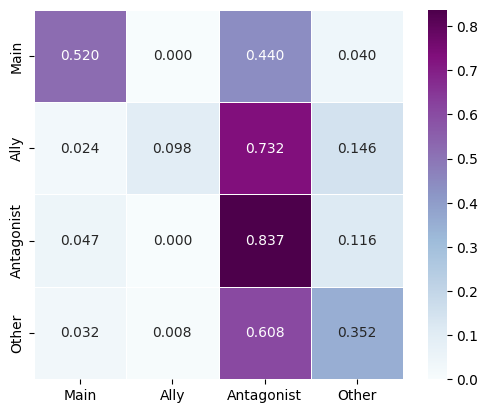

In [ ]:

train_labels = get_labels_all(train_G_solo_c)

test_labels = get_labels_all(test_G_solo_c)
num_classes = 4
classes = [0,1 ,2,3]




train_dataset_mask_events = MyDataset(train_G_solo_c, [i for i in train_labels], ['Feature'], num_classes)
train_data_mask_events = train_dataset_mask_events[0]
train_data_mask_events

test_dataset_mask_events = MyDataset(test_G_solo_c, [i for i in test_labels], ['Feature'], num_classes)
test_data_mask_events = test_dataset_mask_events[0]
test_data_mask_events


# Move all your data to the same device
train_data_mask_events =  train_data_mask_events.to(device)
test_data_mask_events =  test_data_mask_events.to(device)

model = ConvModel(train_data_mask_events).to(device)

model
class_weights = compute_class_weights(train_labels)

train_TEST_2_5(model, train_data_mask_events,2000,class_weights)

test_TEST_2_5(model, test_data_mask_events,classes= ["Main", "Ally", "Antagonist","Other"])

## Char graph Recap SageModel

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_train_G_solo_c-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_train_G_solo_c.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_train_G_solo_c-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_last_layer_cleand" :
  g_file_name += "C1_C2_train_G_solo_c-last_layers_cleand.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
train_G_solo_c = load_graph(load_graph_name)

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_test_G_solo_c-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_test_G_solo_c.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_test_G_solo_c-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_last_layer_cleand" :
  g_file_name += "C1_C2_test_G_solo_c-last_layers_cleand.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
test_G_solo_c = load_graph(load_graph_name)

Epoch   0 | Loss: 1.56 | Acc: 19.23%
Epoch  50 | Loss: 1.23 | Acc: 39.74%
Epoch 100 | Loss: 1.16 | Acc: 38.89%
Epoch 150 | Loss: 1.13 | Acc: 38.46%
Epoch 200 | Loss: 1.07 | Acc: 44.44%
Epoch 250 | Loss: 1.02 | Acc: 38.89%
Epoch 300 | Loss: 1.06 | Acc: 49.15%
Epoch 350 | Loss: 0.99 | Acc: 43.59%
Epoch 400 | Loss: 0.98 | Acc: 45.73%
Epoch 450 | Loss: 0.97 | Acc: 53.42%
Epoch 500 | Loss: 0.93 | Acc: 57.26%
Epoch 550 | Loss: 1.01 | Acc: 50.85%
Epoch 600 | Loss: 0.91 | Acc: 54.70%
Epoch 650 | Loss: 0.90 | Acc: 55.98%
Epoch 700 | Loss: 0.90 | Acc: 51.28%
Epoch 750 | Loss: 0.90 | Acc: 49.57%
Epoch 800 | Loss: 0.90 | Acc: 53.85%
Epoch 850 | Loss: 0.90 | Acc: 58.12%
Epoch 900 | Loss: 0.90 | Acc: 48.72%
Epoch 950 | Loss: 0.84 | Acc: 52.99%
Epoch 1000 | Loss: 0.85 | Acc: 58.97%
Epoch 1050 | Loss: 0.82 | Acc: 56.41%
Epoch 1100 | Loss: 0.89 | Acc: 54.27%
Epoch 1150 | Loss: 0.75 | Acc: 64.96%
Epoch 1200 | Loss: 0.79 | Acc: 65.38%
Epoch 1250 | Loss: 0.86 | Acc: 59.40%
Epoch 1300 | Loss: 0.75 | Acc: 5

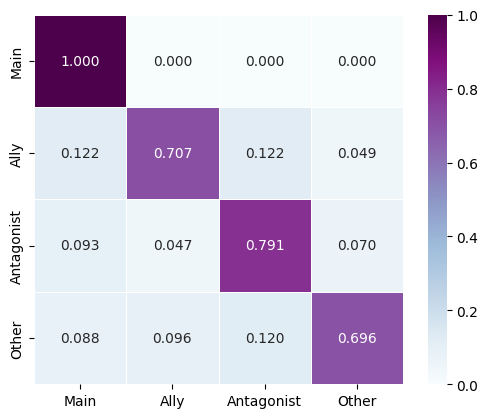

In [ ]:

train_labels = get_labels_all(train_G_solo_c)

test_labels = get_labels_all(test_G_solo_c)
num_classes = 4
classes = [0,1 ,2,3]




train_dataset_mask_events = MyDataset(train_G_solo_c, [i for i in train_labels], ['Feature'], num_classes)
train_data_mask_events = train_dataset_mask_events[0]
train_data_mask_events

test_dataset_mask_events = MyDataset(test_G_solo_c, [i for i in test_labels], ['Feature'], num_classes)
test_data_mask_events = test_dataset_mask_events[0]
test_data_mask_events


# Move all your data to the same device
train_data_mask_events =  train_data_mask_events.to(device)
test_data_mask_events =  test_data_mask_events.to(device)

model = SageModel(train_data_mask_events).to(device)

model
class_weights = compute_class_weights(train_labels)

train_TEST_2_5(model, train_data_mask_events,3000,class_weights)

test_TEST_2_5(model, test_data_mask_events,classes= ["Main", "Ally", "Antagonist","Other"])

## Event/Char graph ConvModel

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_train_G-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_train_G.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_train_G-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT =="C1_C2_last_layer_cleand":
  g_file_name += "C1_C2_train_G-last_layer-cleands.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
train_G = load_graph_event_char(load_graph_name)

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer" :
  g_file_name += "C1_C2_test_G-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_test_G.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_test_G-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT =="C1_C2_last_layer_cleand":
  g_file_name += "C1_C2_test_G-last_layer-cleand.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
test_G = load_graph_event_char(load_graph_name)

Epoch   0 | Loss: 1.66 | Acc: 34.13%
Epoch  50 | Loss: 1.20 | Acc: 37.59%
Epoch 100 | Loss: 1.03 | Acc: 40.11%
Epoch 150 | Loss: 1.01 | Acc: 43.93%
Epoch 200 | Loss: 0.94 | Acc: 47.14%
Epoch 250 | Loss: 0.91 | Acc: 50.00%
Epoch 300 | Loss: 0.82 | Acc: 53.73%
Epoch 350 | Loss: 0.79 | Acc: 58.87%
Epoch 400 | Loss: 0.77 | Acc: 60.79%
Epoch 450 | Loss: 0.70 | Acc: 66.49%
Epoch 500 | Loss: 0.68 | Acc: 70.45%
Epoch 550 | Loss: 0.66 | Acc: 75.66%
Epoch 600 | Loss: 0.64 | Acc: 75.55%
Epoch 650 | Loss: 0.63 | Acc: 77.98%
Epoch 700 | Loss: 0.65 | Acc: 80.62%
Epoch 750 | Loss: 0.58 | Acc: 81.54%
Epoch 800 | Loss: 0.53 | Acc: 83.49%
Epoch 850 | Loss: 0.51 | Acc: 83.81%
Epoch 900 | Loss: 0.54 | Acc: 86.61%
Epoch 950 | Loss: 0.51 | Acc: 86.78%
Epoch 1000 | Loss: 0.50 | Acc: 88.23%
Epoch 1050 | Loss: 0.49 | Acc: 88.66%
Epoch 1100 | Loss: 0.45 | Acc: 90.70%
Epoch 1150 | Loss: 0.42 | Acc: 89.07%
Epoch 1200 | Loss: 0.44 | Acc: 90.63%
Epoch 1250 | Loss: 0.43 | Acc: 90.67%
Epoch 1300 | Loss: 0.36 | Acc: 9

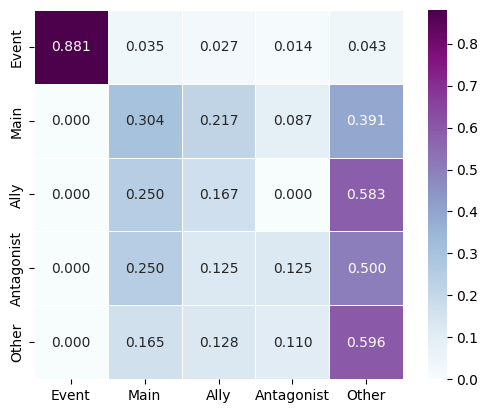

In [ ]:

train_labels = get_labels_all_event(train_G)

test_labels = get_labels_all_event(test_G)
num_classes = 5
classes = [0,1 ,2,3,4]




train_dataset_mask_events = MyDataset(train_G, [i for i in train_labels], ['Feature'], num_classes)
train_data_mask_events = train_dataset_mask_events[0]
train_data_mask_events

test_dataset_mask_events = MyDataset(test_G, [i for i in test_labels], ['Feature'], num_classes)
test_data_mask_events = test_dataset_mask_events[0]
test_data_mask_events


# Move all your data to the same device
train_data_mask_events =  train_data_mask_events.to(device)
test_data_mask_events =  test_data_mask_events.to(device)

model = ConvModel(train_data_mask_events).to(device)

model
class_weights = [0.3] + compute_class_weights(train_labels)[1:]

train_TEST_1_8(model, train_data_mask_events,2000,class_weights)

test_TEST_1_8(model, test_data_mask_events, classes= ["Event", "Main", "Ally", "Antagonist","Other"])

## Event/Char graph SageModel

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_train_G-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_train_G.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_train_G-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT =="C1_C2_last_layer_cleand":
  g_file_name += "C1_C2_train_G-last_layer-cleands.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
train_G = load_graph_event_char(load_graph_name)

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer" :
  g_file_name += "C1_C2_test_G-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_test_G.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_test_G-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT =="C1_C2_last_layer_cleand":
  g_file_name += "C1_C2_test_G-last_layer-cleand.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
test_G = load_graph_event_char(load_graph_name)

Epoch   0 | Loss: 1.98 | Acc: 13.66%
Epoch  50 | Loss: 1.30 | Acc: 26.30%
Epoch 100 | Loss: 1.10 | Acc: 34.00%
Epoch 150 | Loss: 0.94 | Acc: 38.58%
Epoch 200 | Loss: 0.87 | Acc: 43.51%
Epoch 250 | Loss: 0.76 | Acc: 51.80%
Epoch 300 | Loss: 0.80 | Acc: 60.14%
Epoch 350 | Loss: 0.58 | Acc: 65.97%
Epoch 400 | Loss: 0.53 | Acc: 72.50%
Epoch 450 | Loss: 0.50 | Acc: 80.00%
Epoch 500 | Loss: 0.43 | Acc: 84.10%
Epoch 550 | Loss: 0.36 | Acc: 87.78%
Epoch 600 | Loss: 0.32 | Acc: 89.74%
Epoch 650 | Loss: 0.33 | Acc: 93.42%
Epoch 700 | Loss: 0.27 | Acc: 94.23%
Epoch 750 | Loss: 0.33 | Acc: 95.51%
Epoch 800 | Loss: 0.27 | Acc: 96.20%
Epoch 850 | Loss: 0.23 | Acc: 96.98%
Epoch 900 | Loss: 0.21 | Acc: 98.05%
Epoch 950 | Loss: 0.20 | Acc: 98.22%
Epoch 1000 | Loss: 0.19 | Acc: 98.55%
Epoch 1050 | Loss: 0.19 | Acc: 98.44%
Epoch 1100 | Loss: 0.17 | Acc: 98.87%
Epoch 1150 | Loss: 0.17 | Acc: 99.02%
Epoch 1200 | Loss: 0.15 | Acc: 99.01%
Epoch 1250 | Loss: 0.17 | Acc: 99.07%
Epoch 1300 | Loss: 0.11 | Acc: 9

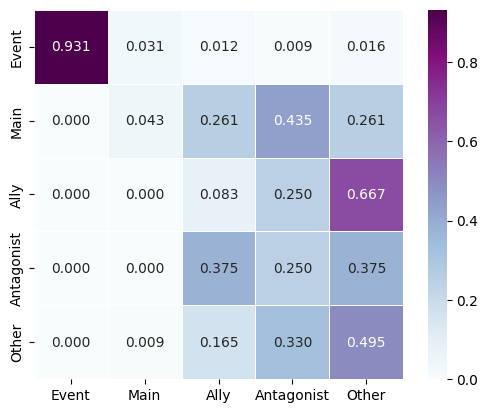

In [ ]:

train_labels = get_labels_all_event(train_G)

test_labels = get_labels_all_event(test_G)
num_classes = 5
classes = [0,1 ,2,3,4]




train_dataset_mask_events = MyDataset(train_G, [i for i in train_labels], ['Feature'], num_classes)
train_data_mask_events = train_dataset_mask_events[0]
train_data_mask_events

test_dataset_mask_events = MyDataset(test_G, [i for i in test_labels], ['Feature'], num_classes)
test_data_mask_events = test_dataset_mask_events[0]
test_data_mask_events


# Move all your data to the same device
train_data_mask_events =  train_data_mask_events.to(device)
test_data_mask_events =  test_data_mask_events.to(device)

model = SageModel(train_data_mask_events).to(device)

model
class_weights = [0.3] + compute_class_weights(train_labels)[1:]

train_TEST_1_8(model, train_data_mask_events,2000,class_weights)

test_TEST_1_8(model, test_data_mask_events, classes= ["Event", "Main", "Ally", "Antagonist","Other"])

# Summary Experiments

In [ ]:
""" scegleire qui se si vuole eseguire su recap o summ"""

recap = False
summ = True

## Char graph Summary ConvModel

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_train_G_solo_c-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_train_G_solo_c.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_train_G_solo_c-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_last_layer_cleand" :
  g_file_name += "C1_C2_train_G_solo_c-last_layers_cleand.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
train_G_solo_c = load_graph(load_graph_name)

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_test_G_solo_c-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_test_G_solo_c.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_test_G_solo_c-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_last_layer_cleand" :
  g_file_name += "C1_C2_test_G_solo_c-last_layers_cleand.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
test_G_solo_c = load_graph(load_graph_name)

Epoch   0 | Loss: 1.50 | Acc: 35.04%
Epoch  50 | Loss: 1.20 | Acc: 44.44%
Epoch 100 | Loss: 1.18 | Acc: 41.88%
Epoch 150 | Loss: 1.17 | Acc: 38.46%
Epoch 200 | Loss: 1.15 | Acc: 41.88%
Epoch 250 | Loss: 1.17 | Acc: 44.87%
Epoch 300 | Loss: 1.17 | Acc: 41.03%
Epoch 350 | Loss: 1.16 | Acc: 38.89%
Epoch 400 | Loss: 1.16 | Acc: 37.61%
Epoch 450 | Loss: 1.15 | Acc: 40.17%
Epoch 500 | Loss: 1.14 | Acc: 39.74%
Epoch 550 | Loss: 1.14 | Acc: 41.88%
Epoch 600 | Loss: 1.16 | Acc: 38.03%
Epoch 650 | Loss: 1.14 | Acc: 38.03%
Epoch 700 | Loss: 1.14 | Acc: 44.44%
Epoch 750 | Loss: 1.14 | Acc: 35.47%
Epoch 800 | Loss: 1.16 | Acc: 41.45%
Epoch 850 | Loss: 1.14 | Acc: 43.59%
Epoch 900 | Loss: 1.14 | Acc: 45.30%
Epoch 950 | Loss: 1.13 | Acc: 44.44%
Epoch 1000 | Loss: 1.15 | Acc: 41.03%
Epoch 1050 | Loss: 1.13 | Acc: 38.03%
Epoch 1100 | Loss: 1.14 | Acc: 38.03%
Epoch 1150 | Loss: 1.13 | Acc: 36.75%
Epoch 1200 | Loss: 1.16 | Acc: 35.90%
Epoch 1250 | Loss: 1.14 | Acc: 33.33%
Epoch 1300 | Loss: 1.13 | Acc: 3

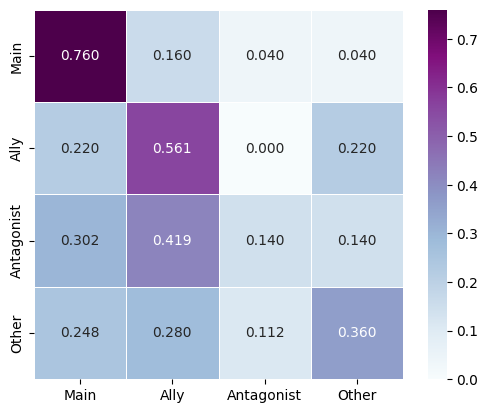

In [ ]:

train_labels = get_labels_all(train_G_solo_c)

test_labels = get_labels_all(test_G_solo_c)
num_classes = 4
classes = [0,1 ,2,3]

train_dataset_mask_events = MyDataset(train_G_solo_c, [i for i in train_labels], ['Feature'], num_classes)
train_data_mask_events = train_dataset_mask_events[0]
train_data_mask_events

test_dataset_mask_events = MyDataset(test_G_solo_c, [i for i in test_labels], ['Feature'], num_classes)
test_data_mask_events = test_dataset_mask_events[0]
test_data_mask_events


# Move all your data to the same device
train_data_mask_events =  train_data_mask_events.to(device)
test_data_mask_events =  test_data_mask_events.to(device)

model = ConvModel(train_data_mask_events).to(device)

model
class_weights = compute_class_weights(train_labels)

train_TEST_2_5(model, train_data_mask_events,2000,class_weights)

test_TEST_2_5(model, test_data_mask_events,classes= ["Main", "Ally", "Antagonist","Other"])

## Char graph Summary SageModel

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_train_G_solo_c-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_train_G_solo_c.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_train_G_solo_c-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_last_layer_cleand" :
  g_file_name += "C1_C2_train_G_solo_c-last_layers_cleand.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
train_G_solo_c = load_graph(load_graph_name)

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_test_G_solo_c-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_test_G_solo_c.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_test_G_solo_c-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_last_layer_cleand" :
  g_file_name += "C1_C2_test_G_solo_c-last_layers_cleand.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
test_G_solo_c = load_graph(load_graph_name)

Epoch   0 | Loss: 1.50 | Acc: 22.22%
Epoch  50 | Loss: 1.21 | Acc: 38.03%
Epoch 100 | Loss: 1.16 | Acc: 37.61%
Epoch 150 | Loss: 1.12 | Acc: 41.45%
Epoch 200 | Loss: 1.07 | Acc: 35.47%
Epoch 250 | Loss: 1.06 | Acc: 43.16%
Epoch 300 | Loss: 1.01 | Acc: 47.01%
Epoch 350 | Loss: 1.00 | Acc: 42.74%
Epoch 400 | Loss: 0.96 | Acc: 48.29%
Epoch 450 | Loss: 1.01 | Acc: 45.73%
Epoch 500 | Loss: 0.97 | Acc: 43.59%
Epoch 550 | Loss: 1.02 | Acc: 52.14%
Epoch 600 | Loss: 0.98 | Acc: 52.56%
Epoch 650 | Loss: 0.92 | Acc: 57.69%
Epoch 700 | Loss: 0.93 | Acc: 58.55%
Epoch 750 | Loss: 0.89 | Acc: 50.85%
Epoch 800 | Loss: 0.89 | Acc: 57.26%
Epoch 850 | Loss: 0.88 | Acc: 50.43%
Epoch 900 | Loss: 0.87 | Acc: 54.27%
Epoch 950 | Loss: 0.84 | Acc: 64.10%
Epoch 1000 | Loss: 0.84 | Acc: 61.11%
Epoch 1050 | Loss: 0.87 | Acc: 57.26%
Epoch 1100 | Loss: 0.92 | Acc: 52.14%
Epoch 1150 | Loss: 0.79 | Acc: 64.53%
Epoch 1200 | Loss: 0.82 | Acc: 58.55%
Epoch 1250 | Loss: 0.85 | Acc: 57.26%
Epoch 1300 | Loss: 0.86 | Acc: 5

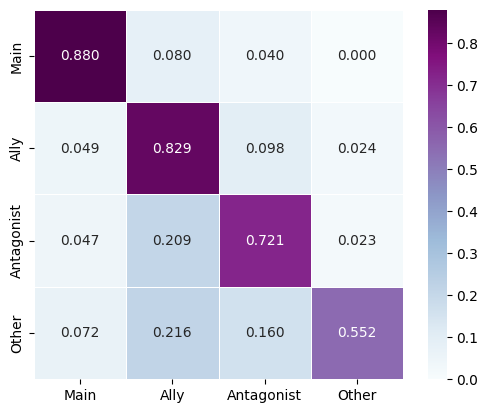

In [ ]:

train_labels = get_labels_all(train_G_solo_c)

test_labels = get_labels_all(test_G_solo_c)
num_classes = 4
classes = [0,1 ,2,3]


train_dataset_mask_events = MyDataset(train_G_solo_c, [i for i in train_labels], ['Feature'], num_classes)
train_data_mask_events = train_dataset_mask_events[0]
train_data_mask_events

test_dataset_mask_events = MyDataset(test_G_solo_c, [i for i in test_labels], ['Feature'], num_classes)
test_data_mask_events = test_dataset_mask_events[0]
test_data_mask_events


# Move all your data to the same device
train_data_mask_events =  train_data_mask_events.to(device)
test_data_mask_events =  test_data_mask_events.to(device)

model = SageModel(train_data_mask_events).to(device)

model
class_weights = compute_class_weights(train_labels)

train_TEST_2_5(model, train_data_mask_events,3000,class_weights)

test_TEST_2_5(model, test_data_mask_events, classes= ["Main", "Ally", "Antagonist","Other"])

## Event/Char graph Summary ConvModel

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_train_G-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_train_G.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_train_G-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT =="C1_C2_last_layer_cleand":
  g_file_name += "C1_C2_train_G-last_layer-cleands.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
train_G = load_graph_event_char(load_graph_name)

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer" :
  g_file_name += "C1_C2_test_G-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_test_G.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_test_G-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT =="C1_C2_last_layer_cleand":
  g_file_name += "C1_C2_test_G-last_layer-cleand.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
test_G = load_graph_event_char(load_graph_name)

Epoch   0 | Loss: 2.22 | Acc: 13.31%
Epoch  50 | Loss: 1.12 | Acc: 40.06%
Epoch 100 | Loss: 1.15 | Acc: 43.52%
Epoch 150 | Loss: 1.03 | Acc: 45.24%
Epoch 200 | Loss: 0.97 | Acc: 51.20%
Epoch 250 | Loss: 0.95 | Acc: 56.71%
Epoch 300 | Loss: 0.82 | Acc: 60.06%
Epoch 350 | Loss: 0.90 | Acc: 62.46%
Epoch 400 | Loss: 0.74 | Acc: 70.25%
Epoch 450 | Loss: 0.69 | Acc: 70.73%
Epoch 500 | Loss: 0.71 | Acc: 75.55%
Epoch 550 | Loss: 0.63 | Acc: 80.22%
Epoch 600 | Loss: 0.70 | Acc: 80.51%
Epoch 650 | Loss: 0.64 | Acc: 82.66%
Epoch 700 | Loss: 0.57 | Acc: 85.13%
Epoch 750 | Loss: 0.59 | Acc: 82.12%
Epoch 800 | Loss: 0.52 | Acc: 85.53%
Epoch 850 | Loss: 0.43 | Acc: 87.30%
Epoch 900 | Loss: 0.46 | Acc: 88.54%
Epoch 950 | Loss: 0.55 | Acc: 88.48%
Epoch 1000 | Loss: 0.47 | Acc: 89.65%
Epoch 1050 | Loss: 0.44 | Acc: 88.94%
Epoch 1100 | Loss: 0.42 | Acc: 89.83%
Epoch 1150 | Loss: 0.46 | Acc: 90.61%
Epoch 1200 | Loss: 0.35 | Acc: 91.86%
Epoch 1250 | Loss: 0.38 | Acc: 91.51%
Epoch 1300 | Loss: 0.37 | Acc: 9

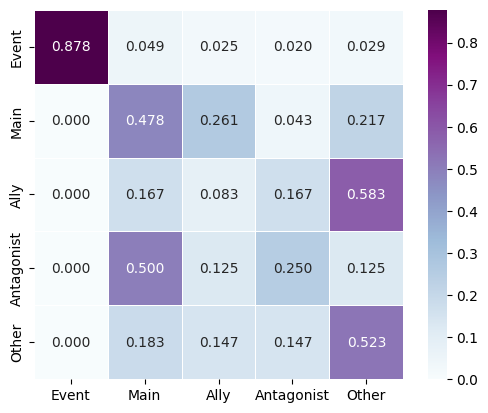

In [ ]:

train_labels = get_labels_all_event(train_G)

test_labels = get_labels_all_event(test_G)
num_classes = 5
classes = [0,1 ,2,3,4]

train_dataset_mask_events = MyDataset(train_G, [i for i in train_labels], ['Feature'], num_classes)
train_data_mask_events = train_dataset_mask_events[0]
train_data_mask_events

test_dataset_mask_events = MyDataset(test_G, [i for i in test_labels], ['Feature'], num_classes)
test_data_mask_events = test_dataset_mask_events[0]
test_data_mask_events


# Move all your data to the same device
train_data_mask_events =  train_data_mask_events.to(device)
test_data_mask_events =  test_data_mask_events.to(device)

model = ConvModel(train_data_mask_events).to(device)

model
class_weights = [0.3] + compute_class_weights(train_labels)[1:]

train_TEST_1_8(model, train_data_mask_events,2000,class_weights)

test_TEST_1_8(model, test_data_mask_events, classes= ["Event", "Main", "Ally", "Antagonist","Other"])

## Event/Char graph Summary SageModel

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer":
  g_file_name += "C1_C2_train_G-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_train_G.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_train_G-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT =="C1_C2_last_layer_cleand":
  g_file_name += "C1_C2_train_G-last_layer-cleands.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
train_G = load_graph_event_char(load_graph_name)

In [ ]:
if summ == True:
  g_file_name = "summ_"
elif recap == True:
  g_file_name = "recap_"
  
if LOAD_FEAT == "C1_C2_last_layer" :
  g_file_name += "C1_C2_test_G-last_layer.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1":
  g_file_name += "C1_test_G.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT == "C1_C2_all_layer":
  g_file_name += "C1_C2_test_G-all_layers.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
elif LOAD_FEAT =="C1_C2_last_layer_cleand":
  g_file_name += "C1_C2_test_G-last_layer-cleand.json"
  load_graph_name = os.path.join(str(GNN_features_PATH), g_file_name)
test_G = load_graph_event_char(load_graph_name)

Epoch   0 | Loss: 1.70 | Acc: 14.79%
Epoch  50 | Loss: 1.28 | Acc: 26.78%
Epoch 100 | Loss: 1.09 | Acc: 31.00%
Epoch 150 | Loss: 0.96 | Acc: 37.79%
Epoch 200 | Loss: 0.91 | Acc: 45.23%
Epoch 250 | Loss: 0.72 | Acc: 55.17%
Epoch 300 | Loss: 0.65 | Acc: 61.65%
Epoch 350 | Loss: 0.59 | Acc: 67.31%
Epoch 400 | Loss: 0.58 | Acc: 75.13%
Epoch 450 | Loss: 0.45 | Acc: 82.59%
Epoch 500 | Loss: 0.44 | Acc: 86.59%
Epoch 550 | Loss: 0.30 | Acc: 90.98%
Epoch 600 | Loss: 0.32 | Acc: 93.35%
Epoch 650 | Loss: 0.43 | Acc: 94.46%
Epoch 700 | Loss: 0.26 | Acc: 95.90%
Epoch 750 | Loss: 0.27 | Acc: 96.54%
Epoch 800 | Loss: 0.35 | Acc: 96.94%
Epoch 850 | Loss: 0.24 | Acc: 97.74%
Epoch 900 | Loss: 0.26 | Acc: 98.54%
Epoch 950 | Loss: 0.21 | Acc: 98.39%
Epoch 1000 | Loss: 0.18 | Acc: 98.29%
Epoch 1050 | Loss: 0.18 | Acc: 98.11%
Epoch 1100 | Loss: 0.20 | Acc: 98.93%
Epoch 1150 | Loss: 0.16 | Acc: 98.53%
Epoch 1200 | Loss: 0.12 | Acc: 98.88%
Epoch 1250 | Loss: 0.13 | Acc: 99.20%
Epoch 1300 | Loss: 0.11 | Acc: 9

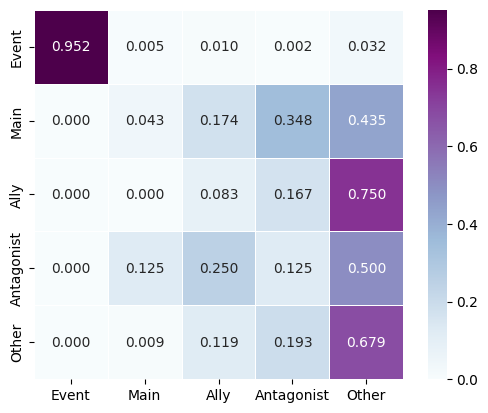

In [ ]:

train_labels = get_labels_all_event(train_G)

test_labels = get_labels_all_event(test_G)
num_classes = 5
classes = [0,1 ,2,3,4]

train_dataset_mask_events = MyDataset(train_G, [i for i in train_labels], ['Feature'], num_classes)
train_data_mask_events = train_dataset_mask_events[0]
train_data_mask_events

test_dataset_mask_events = MyDataset(test_G, [i for i in test_labels], ['Feature'], num_classes)
test_data_mask_events = test_dataset_mask_events[0]
test_data_mask_events


# Move all your data to the same device
train_data_mask_events =  train_data_mask_events.to(device)
test_data_mask_events =  test_data_mask_events.to(device)

model = SageModel(train_data_mask_events).to(device)

model
class_weights = [0.3] + compute_class_weights(train_labels)[1:]

train_TEST_1_8(model, train_data_mask_events,2000,class_weights)

test_TEST_1_8(model, test_data_mask_events, classes= ["Event","Main", "Ally", "Antagonist","Other"])